In [1]:
#import modules
import numpy as np
import pandas as pd
import time
import math
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
original_df = pd.read_csv('./Sub0-RAW.csv')
original_df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
new_df = original_df.filter(train_cols, axis=1)

In [5]:

#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual


In [6]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [7]:
#40 percent data for first training
l_40 = math.floor(0.4*len(original_df))
#40 percent for prediction
l_80 = math.floor(0.8*len(original_df))

In [8]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [9]:
x_train = lag_df[:l_40].loc[:,train_cols].values
y_train = lag_df[:l_40].loc[:,label_cols].values
x_test = lag_df[l_40:l_80].loc[:,train_cols].values
y_test = lag_df[l_40:l_80].loc[:,label_cols].values 

In [10]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

# Saving actual train and test y_label
y_train_actual = y_train
y_test_actual = y_test

In [11]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (74199, 18, 3) (74199,)



length of time-series i/o (74200, 18, 3) (74200,)


In [12]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    conv1 = Conv1D(filters=16, kernel_size=3, strides=1,
                    padding='same',activation='relu')(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv1)
    conv3 = Conv1D(filters=64, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv2)

    flatten = Flatten()(conv3)

    dense1 = Dense(1152, activation='relu')(flatten)
    dense2 = Dense(576, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [13]:
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []

mse_for_iter1 = []
train_loss_over_epoch1 = []
val_loss_over_epoch1 = []
predicted_y_values1_unnors = []


In [14]:
def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
                
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values, predicted_y_values_unnor, model

predicted_y_values, predicted_y_values_unnor, model = run_iteration(1,10)

Iteration: 1
Epoch 1/10
2319/2319 [==============================] - 44s 5ms/step - loss: 6.4982e-04 - val_loss: 1.8759e-05
Epoch 2/10
2319/2319 [==============================] - 10s 4ms/step - loss: 4.3369e-05 - val_loss: 2.5168e-05
Epoch 3/10
2319/2319 [==============================] - 10s 4ms/step - loss: 3.5057e-05 - val_loss: 1.2164e-05
Epoch 4/10
2319/2319 [==============================] - 10s 4ms/step - loss: 2.8029e-05 - val_loss: 6.1438e-06
Epoch 5/10
2319/2319 [==============================] - 11s 5ms/step - loss: 2.3855e-05 - val_loss: 1.1569e-05
Epoch 6/10
2319/2319 [==============================] - 11s 5ms/step - loss: 1.6534e-05 - val_loss: 8.5588e-06
Epoch 7/10
2319/2319 [==============================] - 10s 4ms/step - loss: 1.0168e-05 - val_loss: 1.1630e-05
Epoch 8/10
2319/2319 [==============================] - 10s 4ms/step - loss: 1.2223e-05 - val_loss: 7.1021e-06
Epoch 9/10
2319/2319 [==============================] - 10s 5ms/step - loss: 6.5423e-06 - val_loss:

In [15]:
#replacing last value of previous test data with the predicted value
len_data = len(X_Test)
for i in range (len_data):
    X_Test[i][17][2] = predicted_y_values[i][0]
    
X_Train1 = np.concatenate((X_Train, X_Test), axis = 0)
Y_Train1 = np.concatenate((Y_Train, Y_Test), axis = 0)

#test data after predicted outflow
x_test1 = lag_df[l_80:].loc[:,train_cols].values
y_test1 = lag_df[l_80:].loc[:,label_cols].values
# Normalizing test data
x_test1_nor = xtest_min_max_scaler.fit_transform(x_test1)
y_test1_nor = ytest_min_max_scaler.fit_transform(y_test1)
# Saving actual test y_label
y_test1_actual = y_test1
#Building timeseries
X_Test1, Y_Test1, Y_test1_actual = timeseries(x_test1_nor, y_test1_nor, y_test1_actual, time_steps=18, out_steps=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)


In [16]:
def run_iteration_model_2(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model1 = make_model(X_Train1)
        #plot_model(model, show_shapes=True)
        model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model1.fit(X_Train1, Y_Train1, epochs=epochs,
                       validation_data=(X_Test1, Y_Test1))
        train_loss_over_epoch1.append(history.history['loss'])
        val_loss_over_epoch1.append(history.history['val_loss'])
        predicted_y_values1 = model1.predict(X_Test1)
        predicted_y_values1_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values1)
        mse_for_iter1.append(mean_squared_error(predicted_y_values1_unnor, Y_test1_actual))
        predicted_y_values1_unnors.append(predicted_y_values1_unnor)
                       
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values1, predicted_y_values1_unnor, model1

predicted_y_values1, predicted_y_values1_unnor, model1 = run_iteration_model_2(1,10)

Iteration: 1
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 4.6947e-04 - val_loss: 5.6092e-05
Epoch 2/10
4638/4638 [==============================] - 16s 3ms/step - loss: 6.2517e-05 - val_loss: 1.3574e-05
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 3.5197e-05 - val_loss: 1.7427e-05
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 2.4359e-05 - val_loss: 1.6901e-05
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 2.6211e-05 - val_loss: 1.4470e-05
Epoch 6/10
4638/4638 [==============================] - 16s 3ms/step - loss: 2.0699e-05 - val_loss: 2.3142e-05
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 2.1117e-05 - val_loss: 1.4902e-05
Epoch 8/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.7071e-05 - val_loss: 1.9751e-05
Epoch 9/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.9454e-05 - val_loss:

In [17]:
def repetativeTraining(n= 10, epochs = 10):
    start_time = time.time()
    for iteration in range(n):
        print(f'Iteration: {iteration + 1}')
        #prediction for real training
        history = model.fit(X_Train, Y_Train, epochs=epochs,
                       validation_data=(X_Test, Y_Test))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
        
        #full data with half original half prediction
        #replacing last value of previous test data with the predicted value
        len_data = len(X_Test)
        for i in range (len_data):
            X_Test[i][17][2] = predicted_y_values[i][0]
            
        X_Train1 = np.concatenate((X_Train, X_Test), axis = 0)
        Y_Train1 = np.concatenate((Y_Train, Y_Test), axis = 0)
        
        #test data after predicted outflow
        x_test1 = lag_df[l_80:].loc[:,train_cols].values
        y_test1 = lag_df[l_80:].loc[:,label_cols].values
        # Normalizing test data
        x_test1_nor = xtest_min_max_scaler.fit_transform(x_test1)
        y_test1_nor = ytest_min_max_scaler.fit_transform(y_test1)
        # Saving actual test y_label
        y_test1_actual = y_test1
        #Building timeseries
        X_Test1, Y_Test1, Y_test1_actual = timeseries(x_test1_nor, y_test1_nor, y_test1_actual, time_steps=18, out_steps=1)
        
        history = model1.fit(X_Train1, Y_Train1, epochs=epochs,
                       validation_data=(X_Test1, Y_Test1))
        train_loss_over_epoch1.append(history.history['loss'])
        val_loss_over_epoch1.append(history.history['val_loss'])
        predicted_y_values1 = model1.predict(X_Test1)
        predicted_y_values1_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values1)
        mse_for_iter1.append(mean_squared_error(predicted_y_values1_unnor, Y_test1_actual))
        predicted_y_values1_unnors.append(predicted_y_values1_unnor)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {n} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values1, predicted_y_values1_unnor, model1

predicted_y_values1, predicted_y_values1_unnor, model1 = repetativeTraining()

Iteration: 1
Epoch 1/10
2319/2319 [==============================] - 11s 5ms/step - loss: 7.2964e-06 - val_loss: 4.8948e-05
Epoch 2/10
2319/2319 [==============================] - 11s 5ms/step - loss: 7.3230e-06 - val_loss: 4.8103e-05
Epoch 3/10
2319/2319 [==============================] - 11s 5ms/step - loss: 6.0353e-06 - val_loss: 6.9716e-05
Epoch 4/10
2319/2319 [==============================] - 11s 5ms/step - loss: 5.4887e-06 - val_loss: 5.3306e-05
Epoch 5/10
2319/2319 [==============================] - 11s 5ms/step - loss: 4.6485e-06 - val_loss: 6.0368e-05
Epoch 6/10
2319/2319 [==============================] - 10s 4ms/step - loss: 7.2233e-06 - val_loss: 6.1420e-05
Epoch 7/10
2319/2319 [==============================] - 11s 5ms/step - loss: 3.6077e-06 - val_loss: 6.6652e-05
Epoch 8/10
2319/2319 [==============================] - 10s 4ms/step - loss: 6.8911e-06 - val_loss: 5.0034e-05
Epoch 9/10
2319/2319 [==============================] - 11s 5ms/step - loss: 4.1316e-06 - val_loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 15s 3ms/step - loss: 3.1069e-05 - val_loss: 2.3242e-05
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 2.2725e-05 - val_loss: 1.8389e-05
Epoch 3/10
4638/4638 [==============================] - 16s 3ms/step - loss: 2.1235e-05 - val_loss: 1.9694e-05
Epoch 4/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.9849e-05 - val_loss: 2.0462e-05
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.7570e-05 - val_loss: 1.6333e-05
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.8294e-05 - val_loss: 1.2969e-05
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.5227e-05 - val_loss: 1.7098e-05
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.5293e-05 - val_loss: 1.6502e-05
Epoch 9/10
4638/4638 [==============================] - 16s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.6553e-05 - val_loss: 1.2154e-05
Epoch 2/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.3550e-05 - val_loss: 1.2279e-05
Epoch 3/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.4500e-05 - val_loss: 1.4379e-05
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.2879e-05 - val_loss: 1.3106e-05
Epoch 5/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.2897e-05 - val_loss: 9.5176e-06
Epoch 6/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.2621e-05 - val_loss: 1.0556e-05
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.1528e-05 - val_loss: 1.1082e-05
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.2089e-05 - val_loss: 1.2375e-05
Epoch 9/10
4638/4638 [==============================] - 16s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.3880e-05 - val_loss: 1.1505e-05
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.0782e-05 - val_loss: 8.7985e-06
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.1491e-05 - val_loss: 8.3029e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.0505e-05 - val_loss: 9.5911e-06
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.0823e-05 - val_loss: 7.7664e-06
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.6664e-06 - val_loss: 8.0601e-06
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.6878e-06 - val_loss: 1.2906e-05
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.3250e-06 - val_loss: 1.0173e-05
Epoch 9/10
4638/4638 [==============================] - 15s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.3092e-05 - val_loss: 8.3540e-06
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.5292e-06 - val_loss: 8.0190e-06
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.0288e-05 - val_loss: 8.0477e-06
Epoch 4/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.8289e-06 - val_loss: 1.4891e-05
Epoch 5/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.6626e-06 - val_loss: 8.8268e-06
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.7738e-06 - val_loss: 8.4070e-06
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.0346e-06 - val_loss: 1.4749e-05
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.7187e-06 - val_loss: 7.8336e-06
Epoch 9/10
4638/4638 [==============================] - 15s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.1054e-05 - val_loss: 8.2667e-06
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.6949e-06 - val_loss: 7.2284e-06
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.6877e-06 - val_loss: 7.2953e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.9432e-06 - val_loss: 7.2260e-06
Epoch 5/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.0855e-06 - val_loss: 7.2496e-06
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.8219e-06 - val_loss: 6.5127e-06
Epoch 7/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.0811e-06 - val_loss: 8.6911e-06
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.4931e-06 - val_loss: 8.3999e-06
Epoch 9/10
4638/4638 [==============================] - 15s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.5575e-06 - val_loss: 6.2917e-06
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.0078e-05 - val_loss: 7.2165e-06
Epoch 3/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.9624e-06 - val_loss: 6.1781e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 1.0018e-05 - val_loss: 1.0799e-05
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.1957e-06 - val_loss: 6.4128e-06
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.0700e-06 - val_loss: 5.9749e-06
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.1823e-06 - val_loss: 6.5894e-06
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.0653e-06 - val_loss: 6.4422e-06
Epoch 9/10
4638/4638 [==============================] - 15s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.0559e-05 - val_loss: 6.8280e-06
Epoch 2/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.4194e-06 - val_loss: 6.2997e-06
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.4761e-06 - val_loss: 5.6549e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.4594e-06 - val_loss: 7.1032e-06
Epoch 5/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.6305e-06 - val_loss: 5.5428e-06
Epoch 6/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.0760e-06 - val_loss: 5.7478e-06
Epoch 7/10
4638/4638 [==============================] - 15s 3ms/step - loss: 7.8171e-06 - val_loss: 7.5466e-06
Epoch 8/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.9238e-06 - val_loss: 5.9851e-06
Epoch 9/10
4638/4638 [==============================] - 15s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.0364e-05 - val_loss: 5.7205e-06
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.3377e-06 - val_loss: 5.5313e-06
Epoch 3/10
4638/4638 [==============================] - 16s 3ms/step - loss: 7.5159e-06 - val_loss: 5.3925e-06
Epoch 4/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.0908e-06 - val_loss: 6.3115e-06
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.8466e-06 - val_loss: 6.9497e-06
Epoch 6/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.2705e-06 - val_loss: 7.1222e-06
Epoch 7/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.2903e-06 - val_loss: 8.1510e-06
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.1011e-06 - val_loss: 8.5305e-06
Epoch 9/10
4638/4638 [==============================] - 16s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.1554e-06 - val_loss: 5.8745e-06
Epoch 2/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.4005e-06 - val_loss: 5.0461e-06
Epoch 3/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.0711e-06 - val_loss: 9.6277e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.0766e-06 - val_loss: 7.7158e-06
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.8575e-06 - val_loss: 8.4572e-06
Epoch 6/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.6675e-06 - val_loss: 9.4667e-06
Epoch 7/10
4638/4638 [==============================] - 16s 3ms/step - loss: 7.9384e-06 - val_loss: 4.8099e-06
Epoch 8/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.0184e-06 - val_loss: 6.8371e-06
Epoch 9/10
4638/4638 [==============================] - 16s 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



length of time-series i/o (37090, 18, 3) (37090,)
Epoch 1/10
4638/4638 [==============================] - 16s 3ms/step - loss: 1.0958e-05 - val_loss: 6.7079e-06
Epoch 2/10
4638/4638 [==============================] - 16s 3ms/step - loss: 7.2913e-06 - val_loss: 5.3869e-06
Epoch 3/10
4638/4638 [==============================] - 15s 3ms/step - loss: 9.0709e-06 - val_loss: 5.7388e-06
Epoch 4/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.2269e-06 - val_loss: 5.0272e-06
Epoch 5/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.3331e-06 - val_loss: 5.9716e-06
Epoch 6/10
4638/4638 [==============================] - 16s 3ms/step - loss: 8.7600e-06 - val_loss: 5.4570e-06
Epoch 7/10
4638/4638 [==============================] - 16s 3ms/step - loss: 9.1284e-06 - val_loss: 6.2546e-06
Epoch 8/10
4638/4638 [==============================] - 15s 3ms/step - loss: 8.2916e-06 - val_loss: 5.4011e-06
Epoch 9/10
4638/4638 [==============================] - 16s 3

In [18]:
model1.save("cnn_model1_three_features_hohp.hdf5")

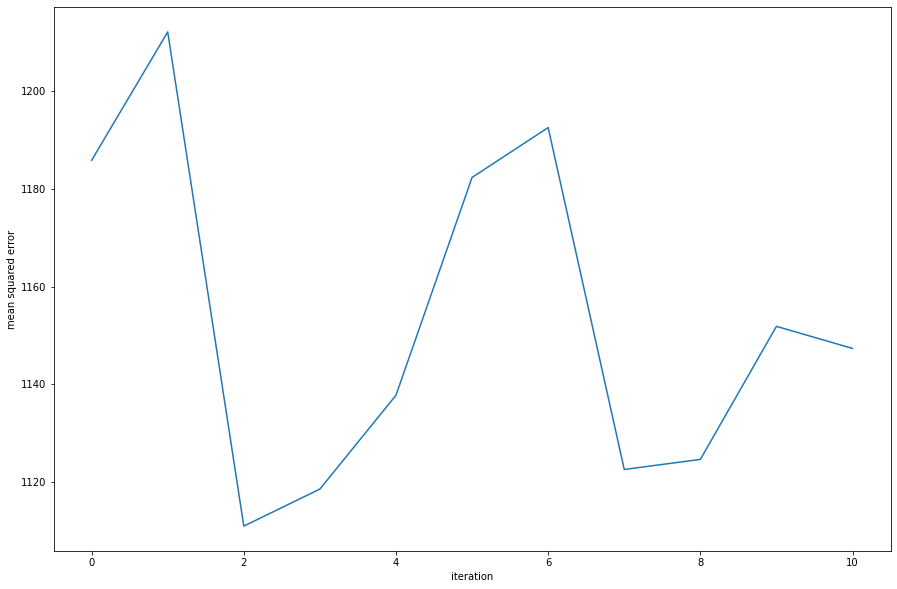

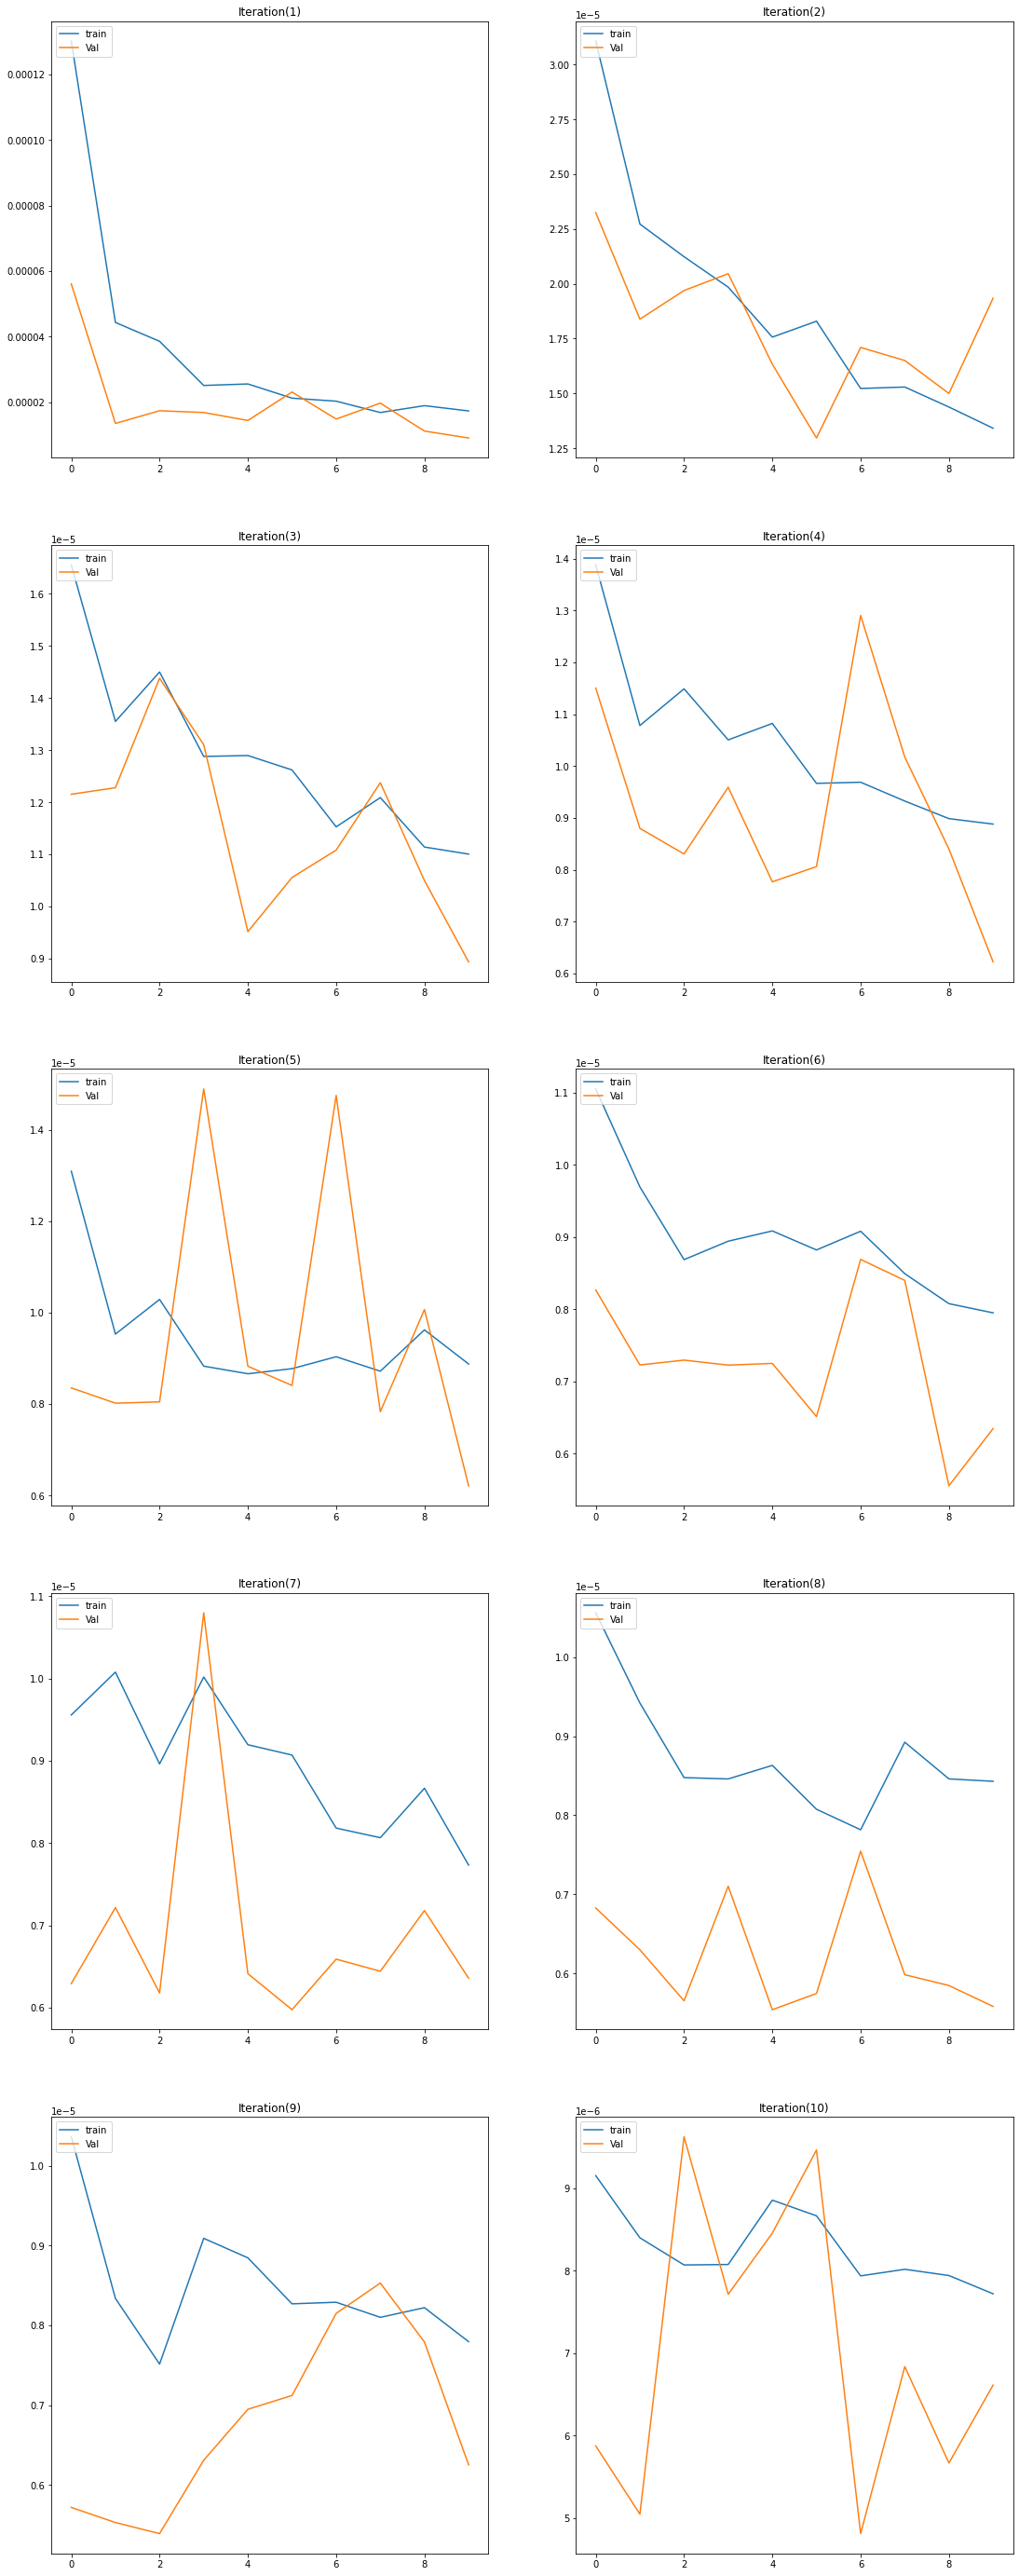

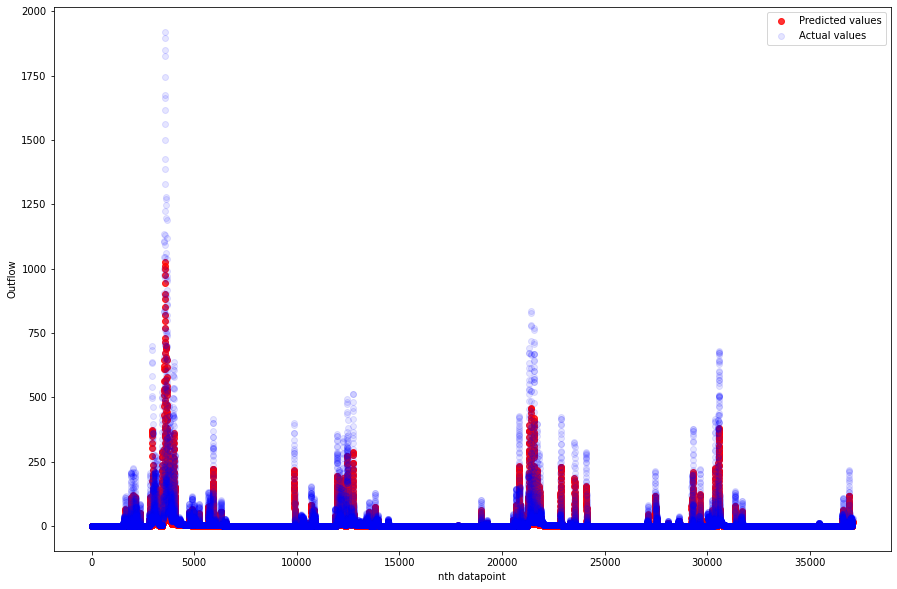

In [19]:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter1)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(5, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(5):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch1[index])
            axs[row, col].plot(val_loss_over_epoch1[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values1_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test1_actual, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [20]:
mse_for_iter1

[1185.8854483423654,
 1212.1988119575815,
 1110.9444002264504,
 1118.5274661571877,
 1137.7586671996876,
 1182.3774914601456,
 1192.6007024995745,
 1122.5453855453134,
 1124.604485563473,
 1151.8704193887177,
 1147.3404058881686]

In [21]:
print(np.mean(mse_for_iter1))

1153.3321531116967


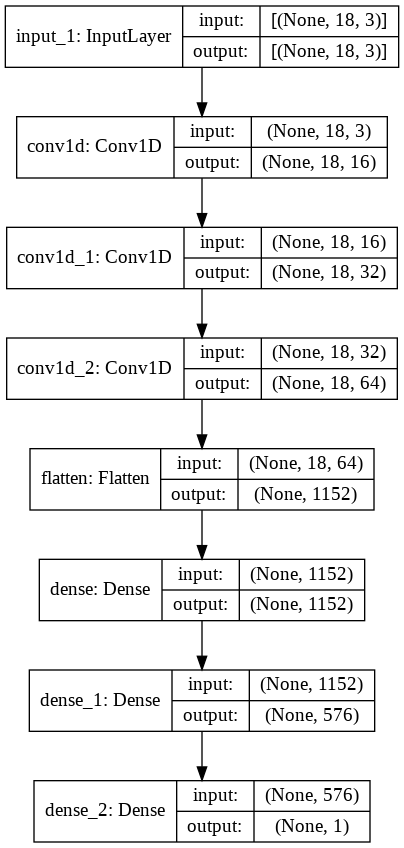

In [22]:
plot_model(model, show_shapes=True)